# Requirements for this notebook:
1. Internet connection (to download corpora and tokenizer data with calls to nltk.download())
2. The following packages:
  1. nltk (Anaconda or PIP command line install : pip install -U nltk OR conda install nltk)
  2. gensim (pip install -U gensim)
  3. scikit-learn v0.18.1 (pip install -U scikit-learn)
  4. matplotlib (pip install -U matplotlib)
  5. numpy (pip install -U numpy)

# Objectives of this notebook are to illustrate how we can do the following with word embeddings:
1. Introduce Document Vectors (Doc2Vec)
2. Compare sentence vectors
3. Use these for text classification

# OK, so having a vector to represent a sequence of words (sentence, paragraph or document) would be useful, but how does it work?  It's very similar to word2vec.  Word2vec predicts a word based on its neighbors or neighbors based on a word.  Doc2Vec is extremely similar but it adds the concept of a "Document ID" which can represent any sequence of text (sentence, paragraph or document)

![Brief Description of Dov2Vec](doc2vec.png)

In [1]:
import time
import nltk
nltk.__version__
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
gensim.__version__

c:\anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


'3.2.0'

In [2]:
import sklearn
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
sklearn.__version__
import numpy as np
np.__version__

c:\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


'1.14.1'

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# download our corpora
%time nltk.download('brown')
%time nltk.download('movie_reviews')
%time nltk.download('treebank')
# Let's download the PUNKT tokenizer first so that we can use tokenize words and sentences
%time nltk.download('punkt')
# Let's download stopwords so we can plot them later
%time nltk.download('stopwords')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
Wall time: 1.72 s
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Wall time: 156 ms
[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
Wall time: 82.9 ms
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Wall time: 63.1 ms
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\slick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Wall time: 3.01 ms


True

In [5]:
from nltk.corpus import brown
from nltk.corpus import movie_reviews
from nltk.corpus import treebank

In [6]:
print(brown.sents()[0])
print(movie_reviews.sents()[0])
print(treebank.sents()[0])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.']
['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']


# Pro Tip : These corpora are relatively small.  We may not get great results.  Certainly not as large as GoogleNews, Wikipedia, PubMed, etc.  Our mileage may vary

In [7]:
# How many sentences do we have in each corpus?
print('Brown sentence count : ', len(brown.sents()))
print('Movie Review sentence count : ', len(movie_reviews.sents()))
print('Treebank sentence count : ', len(treebank.sents()))

Brown sentence count :  57340
Movie Review sentence count :  71532
Treebank sentence count :  3914


In [8]:
# Let's determine what parameters we will use for the doc2vec training
D2V_SKIP_GRAM = 0
D2V_DIMENSIONS = 100
D2V_MIN_COUNT = 3
# How many worker threads should we use to train?  Depends on your hardware...
D2V_WORKERS = 1

# Now let's do something slightly different and set up a document-level Doc2Vec model and use this for classification (also using Gensim)

In [9]:
# PRO TIP : This is a generator class (notice the __iter__() and the yield)
# This makes setting up a "LabeledSentence" class much easier and it becomes almost essential when training large 
# models for either Word2Vec or Doc2Vec since some corpora are so large that we cannot keep them in memory while training
# the vector model.  Therefore, you can "iterate" through files or database rows and only keep batches of them 
# in memory at a time
class TaggedNltkSentence(object):
    def __init__(self, nltk_corpus, max_training_documents = -1):
        self.nltk_corpus = nltk_corpus
        self.max_training_documents = max_training_documents
    def __iter__(self):
        sent_idx = 0
        sentences = self.nltk_corpus.sents()
        
        if self.max_training_documents > 0:
            sentence_count_before = len(sentences)
            sentences = sentences[:self.max_training_documents]
            print('Using a smaller training set.  Reducing from size : {0} to {1}'.format(sentence_count_before, len(sentences)))
            
        for sent in sentences:
            sent_idx += 1
            # NOTE : These tags are not actually used during training time, but they are used
            # to index and potentially query to find similar sentences/paragraphs/documents in GenSim
            yield TaggedDocument(words=sent, tags=['SENT_%s' % sent_idx])

In [10]:
%%time 

print('Training a Doc2Vec model.  This can take some time...')
movie_d2v_model = Doc2Vec(TaggedNltkSentence(movie_reviews), 
                                size = D2V_DIMENSIONS, 
                                min_count = D2V_MIN_COUNT, 
                                workers = D2V_WORKERS)

print('Done training Doc2Vec model.')

Training a Doc2Vec model.  This can take some time...
Done training Doc2Vec model.
Wall time: 1min 41s


# Now that we have a model, let's try it out by comparing some sentences

In [21]:
# In this example, the average embeddings vectors for sentence_1 and sentence_2 would be the same
# However, doc2vec sees them as different.  This will allow context to be handled differently and a classifier
# will be able to learn about these differences

sentence_1 = 'I loved this great movie'
sentence_2 = 'I loved this fantastic film'
sentence_3 = 'boring and terrible'
sentence_texts = [sentence_1, sentence_2, sentence_3]

sentence_vectors = []
for sentence_text in sentence_texts:
    sentence_vec = movie_d2v_model.infer_vector(nltk.tokenize.word_tokenize(sentence_text))
    sentence_vec = sentence_vec.reshape(1, -1)
    sentence_vectors.append(sentence_vec)

for i in range(len(sentence_vectors)):
    for j in range(len(sentence_vectors)):
        if i == j:
            continue
        print('*************')
        print('{0} similarity score comparing [{1}] to [{2}]'.format(
             sklearn.metrics.pairwise.cosine_similarity(sentence_vectors[i], sentence_vectors[j]),
             sentence_texts[i],
             sentence_texts[j]))

print('DONE comparing sentences')

*************
[[0.76293653]] similarity score comparing [I loved this great movie] to [I loved this fantastic film]
*************
[[0.37942412]] similarity score comparing [I loved this great movie] to [boring and terrible]
*************
[[0.76293653]] similarity score comparing [I loved this fantastic film] to [I loved this great movie]
*************
[[0.35001126]] similarity score comparing [I loved this fantastic film] to [boring and terrible]
*************
[[0.37942412]] similarity score comparing [boring and terrible] to [I loved this great movie]
*************
[[0.35001126]] similarity score comparing [boring and terrible] to [I loved this fantastic film]
DONE comparing sentences


# Now let's try to visualize some of the embeddings vectors with reduced dimensions (by way of t-SNE)

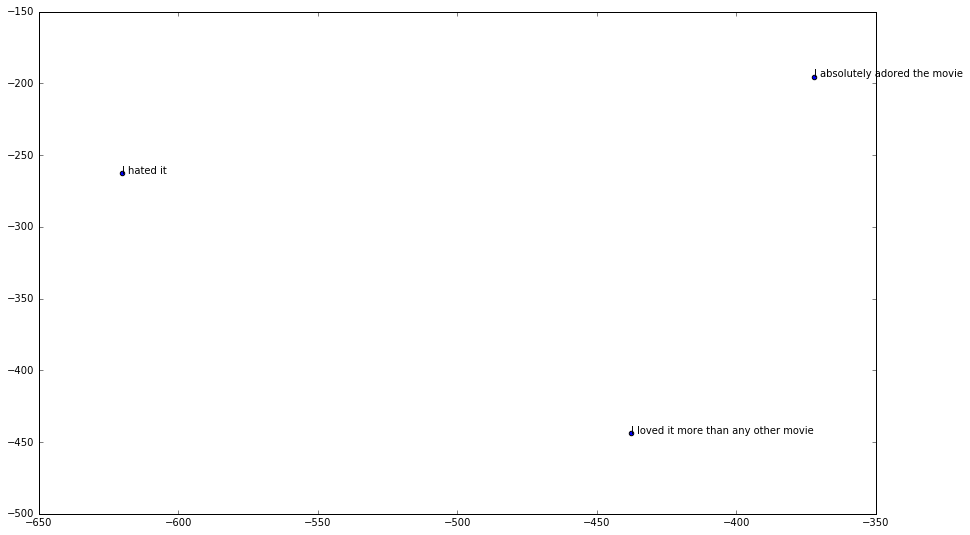

In [12]:
def plot_sentences(d2v_model, target_sentences):
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    sentence_vectors = []
    # let's make sure that a term we want is in the model
    for target_sentence in target_sentences:
        document_tokens = target_sentence.split()
        sentence_vector = d2v_model.infer_vector(document_tokens)
        sentence_vectors.append(sentence_vector)
    Y = tsne.fit_transform(sentence_vectors)
    
    # let's make this plot a decent size...
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width and height
    fig_size[0] = 15
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size
 
    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(target_sentences, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()
    
target_plot_sentences = ['I absolutely adored the movie', 'I loved it more than any other movie', 'I hated it']
plot_sentences(movie_d2v_model, target_plot_sentences)

# Now let's get ready to use these sentence vectors in a text classification task

In [13]:
class Doc2VecVectorizer(object):
    def __init__(self, d2v_model):
        self.d2v_model = d2v_model

    def fit(self, X, y):
        return self

    def transform(self, X):
        # NOTE : infer_vector can take a list of strings (words) of arbitrary lenghth and infer a vector
        # given its model parameters
        return [self.d2v_model.infer_vector(doc) for doc in X]

In [14]:
X = [movie_reviews.words(fileid) for fileid in movie_reviews.fileids()]
# these are the categories
y_categories = [movie_reviews.categories(fileid)[0] for fileid in movie_reviews.fileids()]
# this maps the strings to 1 -> positive 0 -> negative (anything else)
y = [1 if category == 'pos' else 0 for category in y_categories ]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 777)

print('TRAIN set size : {}'.format(len(X_train)))
print('TEST set size : {}'.format(len(X_test)))

TRAIN set size : 1600
TEST set size : 400


# Let's transform all of our sentences into vectors to use them in text classification

In [15]:
%%time

X_train_vectors = [movie_d2v_model.infer_vector(doc) for doc in X_train]
X_test_vectors = [movie_d2v_model.infer_vector(doc) for doc in X_test]

print('TRAIN transformed vector size : {}'.format(len(X_train_vectors)))
print('TEST transformed vector size : {}'.format(len(X_test_vectors)))

TRAIN transformed vector size : 1600
TEST transformed vector size : 400
Wall time: 39.9 s


In [16]:
%%time

print('Training the model...  this could take some time')
lr = LogisticRegression()
lr.fit(X_train_vectors, y_train)

d2v_f1 = f1_score(y_test, lr.predict(X_test_vectors))
print('Doc2Vec F1 : {}'.format(d2v_f1))

Training the model...  this could take some time
Doc2Vec F1 : 0.7142857142857143
Wall time: 88.2 ms


# As one more experiment, let's examine the impact of how many documents we use to train the unsupervised Doc2Vec model

In [17]:
%%time 

SMALL_DOCUMENT_COUNT = 500

print('Training a smaller Doc2Vec model.  This can take some time...')
movie_d2v_model_small = Doc2Vec(TaggedNltkSentence(movie_reviews, max_training_documents = SMALL_DOCUMENT_COUNT), 
                                size = D2V_DIMENSIONS, 
                                min_count = D2V_MIN_COUNT, 
                                workers = D2V_WORKERS)

print('Done training Doc2Vec model.')

Training a smaller Doc2Vec model.  This can take some time...
Using a smaller training set.  Reducing from size : 71532
To a training size of : 500
Using a smaller training set.  Reducing from size : 71532
To a training size of : 500
Using a smaller training set.  Reducing from size : 71532
To a training size of : 500
Using a smaller training set.  Reducing from size : 71532
To a training size of : 500
Using a smaller training set.  Reducing from size : 71532
To a training size of : 500
Using a smaller training set.  Reducing from size : 71532
To a training size of : 500
Done training Doc2Vec model.
Wall time: 47.4 s


In [18]:
%%time

X_train_vectors_small = [movie_d2v_model_small.infer_vector(doc) for doc in X_train]
X_test_vectors_small = [movie_d2v_model_small.infer_vector(doc) for doc in X_test]

print('TRAIN smaller transformed vector size : {}'.format(len(X_train_vectors)))
print('TEST smaller transformed vector size : {}'.format(len(X_test_vectors)))

TRAIN smaller transformed vector size : 1600
TEST smaller transformed vector size : 400
Wall time: 26 s


In [19]:
%%time

print('Training the smaller model...  this could take some time')
lr_small = LogisticRegression()
lr_small.fit(X_train_vectors_small, y_train)

d2v_f1_small = f1_score(y_test, lr_small.predict(X_test_vectors_small))
print('Doc2Vec (smaller training size) F1 : {}'.format(d2v_f1_small))

Training the smaller model...  this could take some time
Doc2Vec (smaller training size) F1 : 0.517766497461929
Wall time: 20.5 ms
